# Experimental

In [1]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import matplotlib.pyplot as plt # plotting library
%matplotlib inline
from keras.models import Sequential
from keras.layers import Dense , Activation, Dropout, Input
from keras.optimizers import Adam ,RMSprop
from keras.utils import to_categorical, plot_model
from keras import  backend as K
from NoisyDense import NoisyDense
import tensorflow as tf
import scipy.optimize

# import dataset
from keras.datasets import mnist

In [2]:
# load dataset
(x_train, y_train),(x_test, y_test) = mnist.load_data()

# count the number of unique train labels
unique, counts = np.unique(y_train, return_counts=True)
print("Train labels: ", dict(zip(unique, counts)))

# count the number of unique test labels
unique, counts = np.unique(y_test, return_counts=True)
print("\nTest labels: ", dict(zip(unique, counts)))

Train labels:  {np.uint8(0): np.int64(5923), np.uint8(1): np.int64(6742), np.uint8(2): np.int64(5958), np.uint8(3): np.int64(6131), np.uint8(4): np.int64(5842), np.uint8(5): np.int64(5421), np.uint8(6): np.int64(5918), np.uint8(7): np.int64(6265), np.uint8(8): np.int64(5851), np.uint8(9): np.int64(5949)}

Test labels:  {np.uint8(0): np.int64(980), np.uint8(1): np.int64(1135), np.uint8(2): np.int64(1032), np.uint8(3): np.int64(1010), np.uint8(4): np.int64(982), np.uint8(5): np.int64(892), np.uint8(6): np.int64(958), np.uint8(7): np.int64(1028), np.uint8(8): np.int64(974), np.uint8(9): np.int64(1009)}


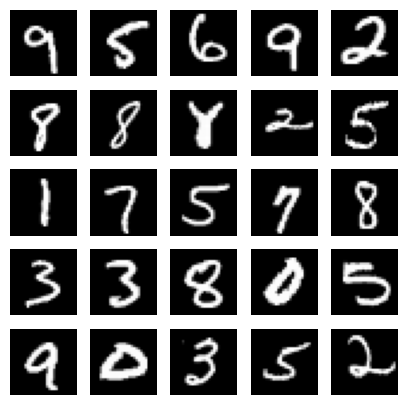

In [3]:
# sample 25 mnist digits from train dataset
indexes = np.random.randint(0, x_train.shape[0], size=25)
images = x_train[indexes]
labels = y_train[indexes]


# plot the 25 mnist digits
plt.figure(figsize=(5,5))
for i in range(len(indexes)):
    plt.subplot(5, 5, i + 1)
    image = images[i]
    plt.imshow(image, cmap='gray')
    plt.axis('off')
    
plt.show()
plt.close('all')

In [4]:
# compute the number of labels
num_labels = len(np.unique(y_train))
# convert to one-hot vector
y_train = to_categorical(y_train)
y_test = to_categorical(y_test)

In [5]:
# image dimensions (assumed square)
image_size = x_train.shape[1]
print(image_size)
input_size = image_size * image_size
input_size

28


784

In [6]:
# resize (flatten) and normalize
print(x_train.shape)
x_train = np.reshape(x_train, [-1, input_size])
x_train = x_train.astype('float32') / 255
x_test = np.reshape(x_test, [-1, input_size])
x_test = x_test.astype('float32') / 255
x_train.shape

(60000, 28, 28)


(60000, 784)

In [7]:
# network parameters
batch_size = 128
hidden_units = 256
dropout = 0.45

In [8]:
# model is a 3-layer MLP with ReLU and dropout after each layer
model = Sequential()
model.add(Input(shape=(input_size,)))
model.add(NoisyDense(units=hidden_units, epsilon=None, delta=1e-5, clip_norm=1.0, spectral_norm_cap=1.0, name="noisy_dense"))
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Dense(hidden_units))
model.add(Activation('relu'))
model.add(Dropout(dropout))
model.add(Dense(num_labels))
model.add(Activation('softmax'))

In [9]:
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ noisy_dense (NoisyDense)        │ (None, 256)            │       200,960 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation (Activation)         │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 256)            │        65,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_1 (Activation)       │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_1 (Dropout)             │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 10)             │         2,570 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ activation_2 (Activation)       │ (None, 10)             │             0 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 269,322 (1.03 MB)

 Trainable params: 269,322 (1.03 MB)

 Non-trainable params: 0 (0.00 B)

In [10]:
plot_model(model, to_file='mlp-mnist.png', show_shapes=True)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [11]:
model.compile(loss='categorical_crossentropy', 
              optimizer='adam',
              metrics=['accuracy'])

In [12]:
model.fit(x_train, y_train, epochs=20, batch_size=batch_size)

Epoch 1/20


/Users/marceli/work/repositories/NFePPML/venv/lib/python3.10/site-packages/keras/src/optimizers/base_optimizer.py:870: UserWarning: Gradients do not exist for variables ['sequential/noisy_dense/bias'] when minimizing the loss. If using `model.compile()`, did you forget to provide a `loss` argument?
  warnings.warn(


469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.8413 - loss: 0.5452
Epoch 2/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9318 - loss: 0.2317
Epoch 3/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9471 - loss: 0.1788
Epoch 4/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9562 - loss: 0.1463
Epoch 5/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9617 - loss: 0.1263
Epoch 6/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9660 - loss: 0.1125
Epoch 7/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9688 - loss: 0.1002
Epoch 8/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9719 - loss: 0.0899
Epoch 9/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9732 - loss: 0.0865
Epoch 10/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9756 - loss: 0.0788
Epoch 11/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy: 0.9760 - loss: 0.0746
Epoch 12/20
469/469 ━━━━━━━━━━━━━━━━━━━━ 1s 2ms/step - accuracy

In [13]:
loss, acc = model.evaluate(x_test, y_test, batch_size=batch_size)
print("\nTest accuracy: %.1f%%" % (100.0 * acc))

79/79 ━━━━━━━━━━━━━━━━━━━━ 0s 729us/step - accuracy: 0.9809 - loss: 0.0660

Test accuracy: 98.1%


### Attack

In [14]:
# Build a submodel that ends at  NoisyDense layer => "attacking" the layer
noisy_layer = model.get_layer("noisy_dense")
w, bias_np = noisy_layer.get_weights() 
layer_model = tf.keras.Model(inputs=model.inputs, outputs=noisy_layer.output)
x = x_train[:100]
z = layer_model.predict(x)
print(w.shape, x.shape, z.shape)

4/4 ━━━━━━━━━━━━━━━━━━━━ 0s 5ms/step 
(784, 256) (100, 784) (100, 256)


In [15]:
def augment(w_rows, b_vals, n, t, period):
    H = W = 28
    for i in range(H):
        for j in range(W):
            if (i + j) % period != 0:
                continue
            # neighbors (4-connected)
            nbrs = []
            for di, dj in ((0,1),(0,-1),(1,0),(-1,0)):
                ii, jj = i + di, j + dj
                if 0 <= ii < H and 0 <= jj < W:
                    nbrs.append(ii * W + jj)
            if not nbrs:
                continue
            # + constraint: x_ij - mean(neighbors) <= t
            row = np.zeros(n, dtype=np.float64)
            row[i * W + j] = 1.0
            row[nbrs] -= 1.0 / len(nbrs)
            w_rows.append(row)
            b_vals.append(t)
            # - constraint: -(x_ij - mean(neighbors)) <= t  <=> mean(neighbors) - x_ij <= t
            row2 = -row.copy()
            w_rows.append(row2)
            b_vals.append(t)

In [20]:
i = 40
z_i = z[i].astype(np.float64)
b_i = bias_np[i].astype(np.float64)
n_vars = w.shape[0]

A_eq = w.T
print(A_eq.shape)
b_eq = z_i - b_i
print(b_eq.shape)
bounds = [(0.0, 1.0)] * n_vars 
c = np.zeros(n_vars, dtype=np.float64)

ineq = []
aineq = []
augment(ineq, aineq, n_vars, t=0.05, period=4)

report = scipy.optimize.linprog(c, A_ub = ineq, b_ub = aineq, A_eq = A_eq, b_eq = b_eq, bounds=bounds, method = "interior-point")

mse = ((x[i] - report['x']) ** 2).mean()
print("MSE: ", mse)

(256, 784)
(256,)


/var/folders/tl/rtq_7xps39d5n2d6h160f3xr0000gn/T/ipykernel_1549/127046668.py:17: DeprecationWarning: `method='interior-point'` is deprecated and will be removed in SciPy 1.11.0. Please use one of the HiGHS solvers (e.g. `method='highs'`) in new code.
  report = scipy.optimize.linprog(c, A_ub = ineq, b_ub = aineq, A_eq = A_eq, b_eq = b_eq, bounds=bounds, method = "interior-point")


MSE:  0.0424260409940407


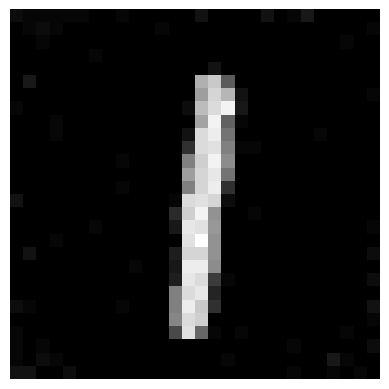

In [21]:
img = report['x'].reshape(28, 28) * 255.0

img_uint8 = img.astype(np.uint8)

# show it
plt.imshow(img_uint8, cmap='gray')
plt.axis('off')
plt.show()
